# Homework 1 — Finding Textually Similar Documents

### Context and Objective

In this project, we aim to **detect textual similarities** between documents using three fundamental techniques in data mining:

- **Shingling**: representing documents as sets of character-based substrings;
- **MinHashing**: approximating Jaccard similarity efficiently;
- **Locality-Sensitive Hashing (LSH)**: identifying candidate pairs without comparing all document combinations.

We initially experimented with two different datasets of textual content, but we found that results were **clearer and easier to interpret** when using a more homogeneous dataset — recipes describing different versions of *lasagna*.  
This setting provides a good balance between textual variety and shared structure (ingredients, steps, etc.), making it ideal for testing document similarity algorithms.


In [1]:
# --- Setup and imports ---

import os
import sys

# --- Setup and imports ---
from src.shingling import create_shingles, hash_shingles
from src.compare_sets import jaccard_similarity
from src.minhashing import generate_hash_functions, compute_minhash_signature
from src.compare_signatures import signature_similarity
from src.lsh import lsh_candidate_pairs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib


print("Modules successfully imported.")


Modules successfully imported.


## 1. Loading and Inspecting the Dataset

We start by loading our collection of **lasagna recipes**, each stored as a plain text file inside the dataset folder.

Each file represents a different variation of lasagna (e.g., *Classic Lasagna*, *Vegetarian Lasagna*, *White Sauce Lasagna*), written in natural English.  
By focusing only on lasagna recipes, we ensure that all documents are topically related but linguistically distinct, which helps the similarity algorithms reveal nuanced relationships instead of trivial differences across unrelated topics.

In [65]:
# --- Load all text files from the data directory ---

data_path = "lasagna_recipes_dataset/"

documents = []
filenames = []

for fname in sorted(os.listdir(data_path)):
    if fname.endswith(".txt"):
        with open(os.path.join(data_path, fname), "r", encoding="utf-8") as f:
            documents.append(f.read())
            filenames.append(fname)

print(f"{len(documents)} documents loaded.\n")
print("Document names:", filenames)
print("\nSample text from the first recipe:\n")
print(documents[0][:400])

7 documents loaded.

Document names: ['Classic_Lasagna.txt', 'Traditional_Lasagna_AlwaysFromScratch.txt', 'Traditional_Lasagna_FeastingAtHome.txt', 'Vegetarian_Lasagna_Arla.txt', 'Vegetarian_Lasagna_BBC.txt', 'Vegetarian_Lasagna_Jamie_Oliver.txt', 'White_Sauce_Lasagna_Mirchi.txt']

Sample text from the first recipe:

Ingredients:
- lasagna sheets; ground beef; Italian sausage; onions; garlic; tomato sauce; oregano, basil; ricotta, Parmesan, mozzarella; eggs; salt & pepper

Preparation:
1. Brown meat with onions and garlic. 2. Add tomato sauce and herbs. 3. Mix ricotta with eggs and Parmesan. 4. Layer sauce, pasta, cheese mixture, mozzarella. 5. Repeat layers, bake until bubbly. 6. Rest before serving.


## 2. Shingling: Representing Documents as Sets

**Shingling** transforms each text document into a set of overlapping substrings of length `k` (called *k-shingles*).  
Each shingle represents a sequence of characters, capturing local context within the text.

This representation allows us to treat each document as a mathematical set, enabling direct computation of the **Jaccard similarity**, which measures how much two sets overlap.  
Choosing the right value of `k` is important, too small captures noise, while too large may miss partial similarities.

## 3. Computing Exact Jaccard Similarity

We compute the **exact Jaccard similarity** between every pair of documents using their shingle sets:

\[
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
\]

The resulting similarity matrix quantifies how textually close two recipes are.  
High similarity values (close to 1) indicate nearly identical recipes, while lower values suggest differences in wording or structure.


Evaluation of k (average of row-wise maxima; global off-diagonal mean):
- k= 2 | avg_row_max=0.7230 | mean_off_diag=0.6294
- k= 3 | avg_row_max=0.5688 | mean_off_diag=0.4229
- k= 4 | avg_row_max=0.4790 | mean_off_diag=0.3240
- k= 5 | avg_row_max=0.4250 | mean_off_diag=0.2700
- k= 6 | avg_row_max=0.3822 | mean_off_diag=0.2296
- k= 7 | avg_row_max=0.3466 | mean_off_diag=0.1991
- k=10 | avg_row_max=0.2713 | mean_off_diag=0.1394
- k=15 | avg_row_max=0.1930 | mean_off_diag=0.0809

Best k based on the average of maximum similarities per row: k=2 (score=0.7230)


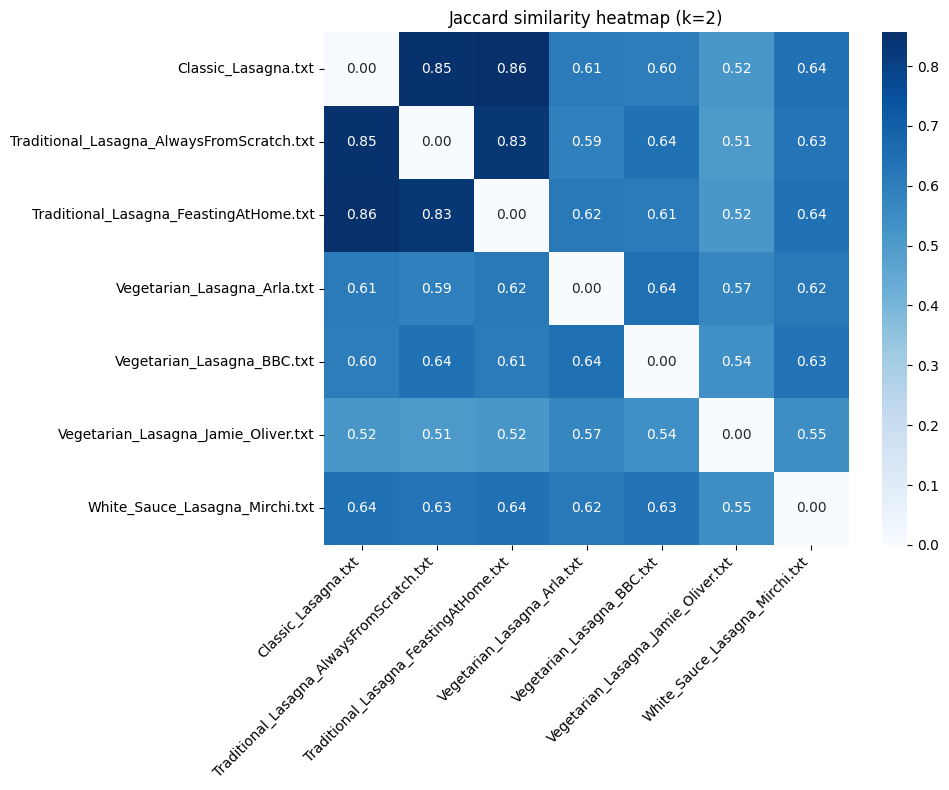

In [117]:
# --- Ricerca del k migliore e visualizzazione heatmap ---

ks = [2,3,4, 5,6, 7, 10, 15]

best_k = None
best_df = None
best_score = -1.0

scores = []  # per stampare le metriche per ogni k

for k in ks:
    # 1) Shingle sets per ciascun documento
    shingle_sets = []
    for doc in documents:
        shingles = create_shingles(doc, k)
        hashed = hash_shingles(shingles)
        shingle_sets.append(hashed)
    
    # 2) Matrice Jaccard
    n = len(shingle_sets)
    jaccard_matrix = np.zeros((n, n), dtype=float)
    
    for i in range(n):
        for j in range(i + 1, n):
            sim = jaccard_similarity(shingle_sets[i], shingle_sets[j])
            jaccard_matrix[i, j] = sim
            jaccard_matrix[j, i] = sim

    # Diagonale = 0.0 (similarità di un set con sé stesso) mettiamo 0 per migliore visualizzazione
    np.fill_diagonal(jaccard_matrix, 0.0)
    
    df_jaccard = pd.DataFrame(jaccard_matrix, index=filenames, columns=filenames)
    
    # 3) Metrica di selezione: media delle massime similarità per riga (escludendo la diagonale)
    # Per ogni riga, prendiamo il massimo su tutte le altre colonne
    row_max = []
    for i in range(n):
        # escludo la diagonale prendendo tutte le colonne tranne i
        max_others = jaccard_matrix[i, np.arange(n) != i].max()
        row_max.append(max_others)
    avg_row_max = float(np.mean(row_max))
    
    # (Opzionale) Media globale off-diagonal, solo come riferimento
    off_diag_mask = ~np.eye(n, dtype=bool)
    mean_off_diag = float(jaccard_matrix[off_diag_mask].mean())
    
    scores.append((k, avg_row_max, mean_off_diag))
    
    # 4) Aggiorna il migliore
    if avg_row_max > best_score:
        best_score = avg_row_max
        best_k = k
        best_df = df_jaccard.copy()

print("Evaluation of k (average of row-wise maxima; global off-diagonal mean):")
for k, s_rowmax, s_off in scores:
    print(f"- k={k:>2} | avg_row_max={s_rowmax:.4f} | mean_off_diag={s_off:.4f}")

print(f"\nBest k based on the average of maximum similarities per row: k={best_k} (score={best_score:.4f})")

# 5) Heatmap for the best k
plt.figure(figsize=(10, 8))
sns.heatmap(best_df, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Jaccard similarity heatmap (k={best_k})")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




In [118]:
# --- Create and hash k-shingles ---

k = 4  # shingle length (characters)
shingle_sets = []

for doc in documents:
    shingles = create_shingles(doc, k)
    hashed = hash_shingles(shingles)
    shingle_sets.append(hashed)

print(f"Created {len(shingle_sets)} shingle sets (one per recipe).")
print(f"Example shingles from first document: {list(create_shingles(documents[0], 10))[:10]}")


Created 7 shingle sets (one per recipe).
Example shingles from first document: ['cotta, par', 's. 3. mix ', '6. rest be', ' bake unti', 'eets; grou', 'x ricotta ', 'peat layer', 'th eggs an', 'sauce and ', 'beef; ital']


In [119]:
n = len(shingle_sets)
jaccard_matrix = [[0]*n for _ in range(n)]

for i in range(n):
    for j in range(n):
        if i < j:
            sim = jaccard_similarity(shingle_sets[i], shingle_sets[j])
            jaccard_matrix[i][j] = jaccard_matrix[j][i] = sim

# Convert to DataFrame for readability
df_jaccard = pd.DataFrame(jaccard_matrix, index=filenames, columns=filenames)

print("Exact Jaccard similarity matrix:")
df_jaccard.round(3)


Exact Jaccard similarity matrix:


,Classic_Lasagna.txt,Traditional_Lasagna_AlwaysFromScratch.txt,Traditional_Lasagna_FeastingAtHome.txt,Vegetarian_Lasagna_Arla.txt,Vegetarian_Lasagna_BBC.txt,Vegetarian_Lasagna_Jamie_Oliver.txt,White_Sauce_Lasagna_Mirchi.txt
Classic_Lasagna.txt,0.000,0.643,0.652,0.275,0.266,0.177,0.292
Traditional_Lasagna_AlwaysFromScratch.txt,0.643,0.000,0.677,0.275,0.303,0.191,0.299
Traditional_Lasagna_FeastingAtHome.txt,0.652,0.677,0.000,0.272,0.277,0.177,0.255
Vegetarian_Lasagna_Arla.txt,0.275,0.275,0.272,0.000,0.364,0.249,0.292
Vegetarian_Lasagna_BBC.txt,0.266,0.303,0.277,0.364,0.000,0.280,0.340
Vegetarian_Lasagna_Jamie_Oliver.txt,0.177,0.191,0.177,0.249,0.280,0.000,0.249
White_Sauce_Lasagna_Mirchi.txt,0.292,0.299,0.255,0.292,0.340,0.249,0.000


### Visualizing Jaccard Similarities

The heatmap below shows the pairwise Jaccard similarities between all lasagna recipes.

As expected, traditional lasagna variants (e.g., *Classic Lasagna*, *Traditional Lasagna from Scratch*) exhibit **high similarity scores** (≈ 0.6), while vegetarian or white-sauce versions are **less similar**, possibly due to difference in the ingredients even being all vegeterians.  
This confirms that Jaccard similarity effectively captures content overlap even in small textual datasets.


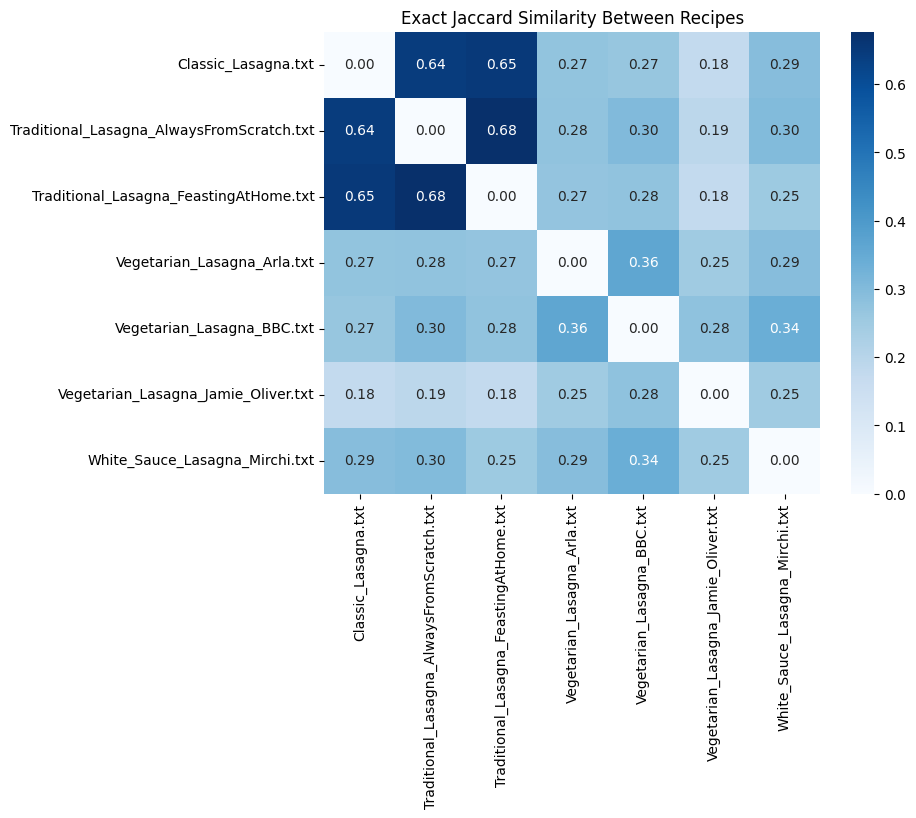

In [120]:
# --- Visualize Jaccard similarities ---

plt.figure(figsize=(8,6))
sns.heatmap(df_jaccard, annot=True, fmt=".2f", cmap="Blues")
plt.title("Exact Jaccard Similarity Between Recipes")
plt.show()


## 4. MinHashing: Efficient Similarity Estimation

Computing the exact Jaccard similarity for large datasets is computationally expensive.  
**MinHashing** offers a scalable approximation by applying multiple random hash functions to the shingles of each document.

Each document is thus represented by a **MinHash signature**, a vector summarizing its content.  
The fraction of equal elements between two signatures provides an unbiased estimate of their Jaccard similarity.

### Comparing Exact and Estimated Similarities

The matrix and heatmap below show the **estimated similarities** using MinHash signatures.  
We can observe that the results are **very close to the exact Jaccard values**, with only minor deviations.  
This demonstrates that MinHashing provides a reliable and efficient approximation while drastically reducing computational cost.


In [127]:
num_hashes = 100
max_shingle_id = 2**32 - 1  # modulus for hash functions

# Generate random hash functions
hash_functions = generate_hash_functions(num_hashes, max_shingle_id)

# Compute signatures for all documents
signatures = []
for s in shingle_sets:
    sig = compute_minhash_signature(s, hash_functions, max_shingle_id)
    signatures.append(sig)

print(f"Computed {len(signatures)} MinHash signatures (length {num_hashes} each).")


Computed 7 MinHash signatures (length 100 each).


In [122]:
# --- Estimate similarity using MinHash signatures ---

minhash_matrix = [[0]*n for _ in range(n)]

for i in range(n):
    for j in range(n):
        if i < j:
            sim = signature_similarity(signatures[i], signatures[j])
            minhash_matrix[i][j] = minhash_matrix[j][i] = sim

df_minhash = pd.DataFrame(minhash_matrix, index=filenames, columns=filenames)

print("Estimated similarities using MinHash:")
df_minhash.round(3)


Estimated similarities using MinHash:


,Classic_Lasagna.txt,Traditional_Lasagna_AlwaysFromScratch.txt,Traditional_Lasagna_FeastingAtHome.txt,Vegetarian_Lasagna_Arla.txt,Vegetarian_Lasagna_BBC.txt,Vegetarian_Lasagna_Jamie_Oliver.txt,White_Sauce_Lasagna_Mirchi.txt
Classic_Lasagna.txt,0.00,0.60,0.58,0.22,0.21,0.17,0.23
Traditional_Lasagna_AlwaysFromScratch.txt,0.60,0.00,0.53,0.23,0.27,0.20,0.28
Traditional_Lasagna_FeastingAtHome.txt,0.58,0.53,0.00,0.21,0.20,0.16,0.20
Vegetarian_Lasagna_Arla.txt,0.22,0.23,0.21,0.00,0.33,0.25,0.24
Vegetarian_Lasagna_BBC.txt,0.21,0.27,0.20,0.33,0.00,0.27,0.33
Vegetarian_Lasagna_Jamie_Oliver.txt,0.17,0.20,0.16,0.25,0.27,0.00,0.26
White_Sauce_Lasagna_Mirchi.txt,0.23,0.28,0.20,0.24,0.33,0.26,0.00


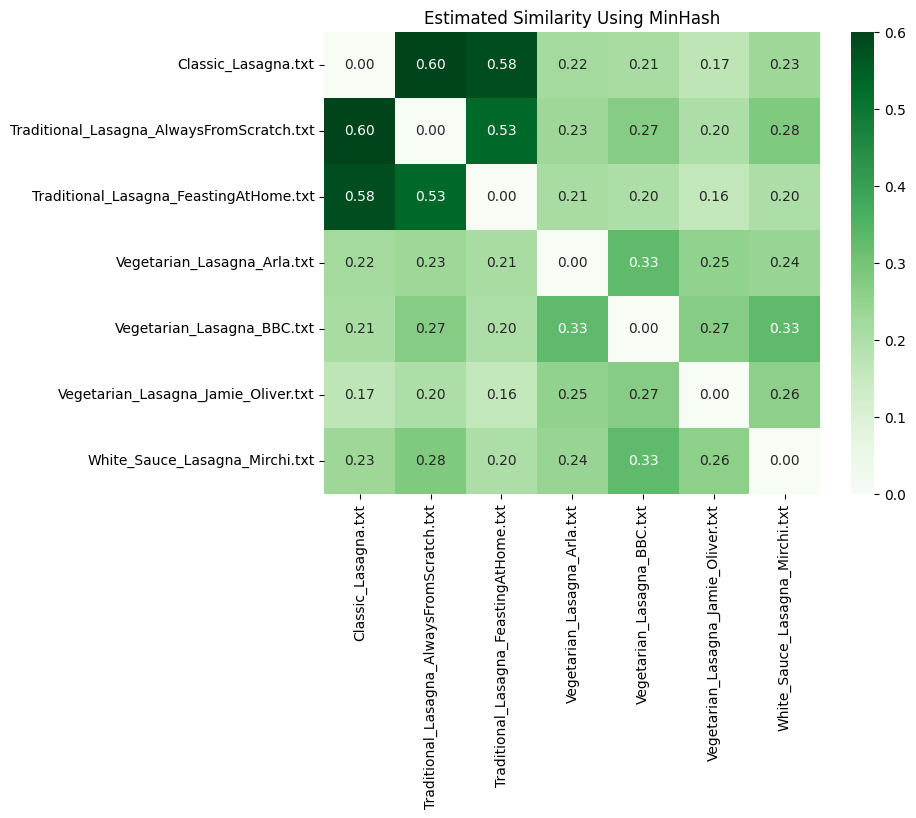

In [123]:
# --- Visualize MinHash-based similarity ---

plt.figure(figsize=(8,6))
sns.heatmap(df_minhash, annot=True, fmt=".2f", cmap="Greens")
plt.title("Estimated Similarity Using MinHash")
plt.show()


## 5. Locality-Sensitive Hashing (LSH)

To further reduce the number of document comparisons, we apply **Locality-Sensitive Hashing (LSH)**.  
This technique divides each signature into *bands* of *rows*.  
Documents that share at least one identical band are considered *candidate pairs*, likely to be similar.

By tuning the number of bands (`b`) and rows (`r`), we can control the trade-off between:
- **False Positives (FP)** — unrelated pairs incorrectly identified as similar;
- **False Negatives (FN)** — similar pairs missed by the algorithm.


In [124]:
bands = 20
rows = 5  # 20 * 5 = 100 (same as number of hash functions)

candidates = lsh_candidate_pairs(signatures, bands, rows)

print("Candidate pairs identified using LSH:")
for (i, j) in candidates:
    print(f"{filenames[i]}  <-->  {filenames[j]}")


Candidate pairs identified using LSH:
Classic_Lasagna.txt  <-->  Traditional_Lasagna_AlwaysFromScratch.txt
Traditional_Lasagna_AlwaysFromScratch.txt  <-->  Traditional_Lasagna_FeastingAtHome.txt


Total pairs: 21, Positives (s≥0.31): 5, Negatives: 16

Results by (bands, rows):


,bands,rows,candidates,TP,FP,FN,precision,recall,f1,FPR,FNR,FP%_among_candidates,FN%_among_positives,s_star_approx
0,25,4,3,3,0,2,1.000000,0.6,0.750000,0.0,0.4,0.000000,0.4,0.447214
1,20,5,2,2,0,3,1.000000,0.4,0.571429,0.0,0.6,0.000000,0.6,0.549280
2,100,1,21,5,16,0,0.238095,1.0,0.384615,1.0,0.0,0.761905,0.0,0.010000
3,50,2,21,5,16,0,0.238095,1.0,0.384615,1.0,0.0,0.761905,0.0,0.141421
4,10,10,0,0,0,5,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.0,0.794328
5,5,20,0,0,0,5,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.0,0.922681
6,4,25,0,0,0,5,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.0,0.946058
7,2,50,0,0,0,5,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.0,0.986233
8,1,100,0,0,0,5,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.0,1.000000


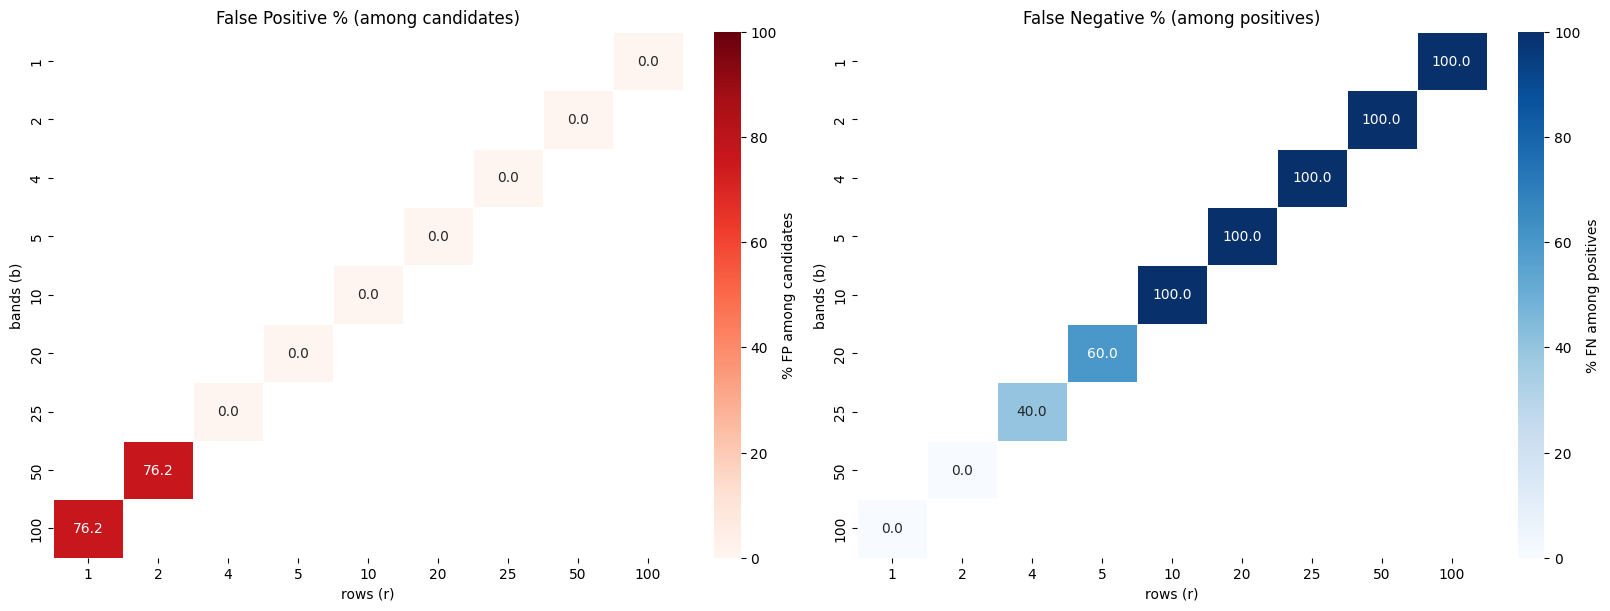


→ Now manually choose bands and rows in the next cell to recompute the metrics.


In [125]:
# --- Grid search over (bands, rows) for LSH + FP/FN metrics compared to df_minhash ---

import math
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assumptions:
# - signatures: list[list[int]] MinHash signatures (all with same length k)
# - filenames: list[str] document names in the same order as signatures
# - df_jaccard: pairwise table of true Jaccard similarities
# - lsh_candidate_pairs(signatures, bands, rows) is already defined

SIM_THRESHOLD = 0.31  # threshold for “similar” documents based on df_jaccard

k = len(signatures[0])
n = len(signatures)

# 1) Align df_jaccard to filenames (if indexed by name)
def align_df(df, names):
    try:
        return df.reindex(index=names, columns=names)
    except Exception:
        return df  # assume already aligned

df_j = align_df(df_jaccard, filenames)

# 2) Build the set of "positive" pairs (i,j) with s >= threshold (only for i<j)
positives = set()
for i in range(n):
    for j in range(i + 1, n):
        s_ij = float(df_j.iat[i, j])
        if s_ij >= SIM_THRESHOLD:
            positives.add((i, j))

total_pairs = n * (n - 1) // 2
num_positives = len(positives)
num_negatives = total_pairs - num_positives

# 3) Generate all (bands, rows) pairs such that bands*rows = k
def factor_pairs(K):
    pairs = []
    for r in range(1, K + 1):
        if K % r == 0:
            b = K // r
            pairs.append((b, r))
    return pairs

br_grid = factor_pairs(k)

results = []

for (b, r) in br_grid:
    # Run LSH and get candidate pairs
    candidates = lsh_candidate_pairs(signatures, b, r)
    candidates = {(min(i, j), max(i, j)) for (i, j) in candidates}

    # Confusion matrix vs ground truth
    TP = len(candidates & positives)
    FP = len(candidates - positives)
    FN = len(positives - candidates)
    TN = total_pairs - TP - FP - FN

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0.0
    fp_pct_candidates = FP / len(candidates) if len(candidates) > 0 else 0.0
    fn_pct_positives = FN / num_positives if num_positives > 0 else 0.0

    s_star = (1 / b) ** (1 / r)

    results.append({
        "bands": b,
        "rows": r,
        "k": k,
        "candidates": len(candidates),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "FPR": fpr,
        "FNR": fnr,
        "FP%_among_candidates": fp_pct_candidates,
        "FN%_among_positives": fn_pct_positives,
        "s_star_approx": s_star,
    })

# 4) Results table
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(
    by=["f1", "FP%_among_candidates", "recall"],
    ascending=[False, True, False],
).reset_index(drop=True)

print(f"Total pairs: {total_pairs}, Positives (s≥{SIM_THRESHOLD}): {num_positives}, Negatives: {num_negatives}\n")
print("Results by (bands, rows):")
display_cols = [
    "bands","rows","candidates",
    "TP","FP","FN",
    "precision","recall","f1",
    "FPR","FNR",
    "FP%_among_candidates","FN%_among_positives",
    "s_star_approx"
]
display(df_results_sorted[display_cols])

# 5) Create FP/FN heatmaps
pivot_fp = df_results.pivot(index="bands", columns="rows", values="FP%_among_candidates").sort_index().sort_index(axis=1)
pivot_fn = df_results.pivot(index="bands", columns="rows", values="FN%_among_positives").sort_index().sort_index(axis=1)

fp_pct = pivot_fp * 100.0
fn_pct = pivot_fn * 100.0

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

sns.heatmap(
    fp_pct, ax=axes[0], cmap="Reds", vmin=0, vmax=100,
    annot=True, fmt=".1f", cbar_kws={"label": "% FP among candidates"},
    linewidths=0.5, linecolor="white"
)
axes[0].set_title("False Positive % (among candidates)")
axes[0].set_xlabel("rows (r)")
axes[0].set_ylabel("bands (b)")

sns.heatmap(
    fn_pct, ax=axes[1], cmap="Blues", vmin=0, vmax=100,
    annot=True, fmt=".1f", cbar_kws={"label": "% FN among positives"},
    linewidths=0.5, linecolor="white"
)
axes[1].set_title("False Negative % (among positives)")
axes[1].set_xlabel("rows (r)")
axes[1].set_ylabel("bands (b)")

plt.show()

print("\n→ Now manually choose bands and rows in the next cell to recompute the metrics.")


In [126]:
# --- Manual selection of (bands, rows) and metric recomputation ---

bands = 20  # ← choose manually
rows = 5   # ← choose manually

# Generate candidate pairs for the chosen configuration
candidates = {(min(i,j), max(i,j)) for (i,j) in lsh_candidate_pairs(signatures, bands, rows)}

TP = len(candidates & positives)
FP = len(candidates - positives)
FN = len(positives - candidates)
TN = total_pairs - TP - FP - FN

# Metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (TP + FN) if (TP + FN) > 0 else 0

# Print results
print(f"\nMetrics for bands={bands}, rows={rows}")
print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")
print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
print(f"FPR={fpr:.4f}, FNR={fnr:.4f}")

if len(candidates) > 0:
    print(f"FP% among candidates = {FP/len(candidates):.4f}")
if num_positives > 0:
    print(f"FN% among positives = {FN/num_positives:.4f}")

print("\nCandidate pairs:")
for i, j in sorted(candidates):
    print(f"{filenames[i]} <--> {filenames[j]}")




Metrics for bands=20, rows=5
TP=2, FP=0, FN=3, TN=16
Precision=1.0000, Recall=0.4000, F1=0.5714
FPR=0.0000, FNR=0.6000
FP% among candidates = 0.0000
FN% among positives = 0.6000

Candidate pairs:
Classic_Lasagna.txt <--> Traditional_Lasagna_AlwaysFromScratch.txt
Traditional_Lasagna_AlwaysFromScratch.txt <--> Traditional_Lasagna_FeastingAtHome.txt


### Evaluating LSH Parameters

The following analysis explores multiple combinations of `bands` and `rows`, showing how they affect precision, recall, and error rates.  
Two heatmaps illustrate the proportion of **false positives** and **false negatives** among candidate pairs.

- Increasing the number of bands (and reducing rows per band) **raises recall** but may increase false positives.
- Fewer bands (and more rows per band) **reduce false positives** but risk missing some similar pairs.

The chosen configuration balances these effects, ensuring that most similar recipes are detected without excessive noise.


## 6. Conclusion

Through this step-by-step exploration, we applied and compared different approaches to measure text similarity:

- **Shingling** provides a robust representation of documents as sets.
- **Exact Jaccard similarity** offers ground-truth precision.
- **MinHashing** efficiently approximates similarity with minimal information loss.
- **Locality-Sensitive Hashing** further scales this process by focusing only on promising candidate pairs.

The lasagna recipe dataset proved ideal for this analysis: all documents are semantically related yet lexically varied, clearly illustrating how each method behaves across different levels of textual similarity.
